# 目的
OHLCとcross pointおよびその後の勢いとの相関を解析する。   
その解析結果をもとに、確実に利益の最小値がプラスになるスキームを構築する。

# 前回までのまとめ
`analysis of ohlc (201807-201811)-2.ipynb`、`analysis of ohlc (20181224-20181231)-2.ipynb`での解析の結果をまとめると次のようになる。

* EMA1とEMA2を与えるN1, N2を変化させてcross pointごとの利益の最小値の期待値を計算すると、前者と後者で利確になるN1, N2の組が異なる。

## このノートで調査する内容
* N1, N2を変え、最も利益の出る組み合わせを探す。

## モジュールと関数の用意

In [1]:
from datetime import datetime
import glob
import itertools
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from mpl_finance import candlestick_ohlc
import numpy as np
import os
import pandas as pd
import pickle

%matplotlib inline

In [2]:
from scipy.signal import lfilter

def calc_EMA(x, N=5):
    """calc_EMA(x, N) -> array-like
    calculate exponential moving average (EMA)
    
    Parameters
    ----------
    x : array-like
        target data series
    N : int (default : 5)
        step for EMA
    
    Returns
    -------
    EMA : array-like
    """
    return _calc_EMA(x, 2./(N + 1.))

def _calc_EMA(x, alpha):
    """ _calc_EMA(x, alpha) -> array-like
    calculate exponential moving average (EMA)
    Adopted from https://qiita.com/toyolab/items/6872b32d9fa1763345d8
    
    Parameters
    ----------
    x : array-like
        target data series
    alpha : float
        characteristic parameter
    
    Returns
    -------
    EMA : array-like
    """
    y,_ = lfilter([alpha], [1,alpha-1], x, zi=[x[0]*(1-alpha)])
    return y

def calc_SMA(df, key="Close", N=5):
    """calc_SMA(df, key="Close", N=5) -> numpy.1darray
    calculate simple moving average (SMA)
    
    Parameters
    ----------
    df : pandas.DataFrame
        dataframe including target data
    key : str (default : 'Close')
        key to the target data
    N : int (default : 5)
        step for SMA
    
    Returns
    -------
    SMA : numpy.1darray
    """
    return df[key].rolling(5).mean().values

def find_cross_points(y1, y2=None):
    """find_cross_points(y1, y2=None) -> numpy.1darray
    find cross points between two data sequences
    If y2 == None, then find the root of y1.
    
    Parameters
    ----------
    y1 : list or numpy.1darray
    y2 : list or numpy.1darray
    
    Returns
    -------
    cross_points : numpy.1darray
    """
    if y2 is None:
        y2 = np.zeros_like(y1)
    if isinstance(y1, list):
        y1 = np.array(y1)
    if isinstance(y2, list):
        y2 = np.array(y2)
    cross_points = np.zeros(len(y1))
    for ii in range(1, len(y1)):
        if y1[ii - 1] >= y2[ii - 1] and y1[ii] < y2[ii]:
            cross_points[ii] = -1
        elif y1[ii - 1] < y2[ii - 1] and y1[ii] >= y2[ii]:
            cross_points[ii] = 1
    return cross_points

In [3]:
def symbolize(dataFrame, k):
    """symbolize(dataFrame, k) -> numpy.1darray
    binalize a k-length OHLC dataset and then convert the binary to decimal number.  
    
    Parameters
    ----------
    dataFrame : pandas.DataFrame
    k : int
    
    Returns
    -------
    dec : numpy.1darray
    """
    if k <= 0:
        raise ValueError("k must be >=1.")
    var_ = (dataFrame["close"] - dataFrame["open"]).values
    dec = np.zeros(len(var_), int)
    
    for ii in range(k-1, len(var_)):
        ind_ = np.array(var_[ii-k+1:ii+1] >= 0, int)
        dec[ii] = int("".join([str(i_) for i_ in ind_]), 2)
    return dec

In [4]:
def peakdet(v, delta, x=None):
    """
        Converted from MATLAB script at http://billauer.co.il/peakdet.html
        Returns two np.arrays
        function [maxtab, mintab]=peakdet(v, delta, x)
        % PEAKDET Detect peaks in a vector
        % [MAXTAB, MINTAB] = PEAKDET(V, DELTA) finds the local
        % maxima and minima ("peaks") in the vector V.
        % MAXTAB and MINTAB consists of two columns. Column 1
        % contains indices in V, and column 2 the found values.
        %
        % With [MAXTAB, MINTAB] = PEAKDET(V, DELTA, X) the indices
        % in MAXTAB and MINTAB are replaced with the corresponding
        % X-values.
        %
        % A point is considered a maximum peak if it has the maximal
        % value, and was preceded (to the left) by a value lower by
        % DELTA.
        % Eli Billauer, 3.4.05 (Explicitly not copyrighted).
        % This function is released to the public domain; Any use is allowed.
    """
    maxtab = []
    mintab = []
    if x is None:
        x = np.arange(len(v))
        v = np.asarray(v)
    if len(v) != len(x):
        sys.exit('Input vectors v and x must have same length')
    if not np.isscalar(delta):
        sys.exit('Input argument delta must be a scalar')
    if delta <= 0:
        sys.exit('Input argument delta must be positive')
    mn, mx = np.Inf, -np.Inf
    mnpos, mxpos = np.NaN, np.NaN
    lookformax = True

    for i in np.arange(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]
        if lookformax:
            if this < mx - delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn + delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True

    return np.array(maxtab), np.array(mintab)

## メイン関数

In [5]:
def main(df, N1, N2, N_dec=5):
    """main(df, N1, N2, N_dec=5) -> dict
    calculate some factors
    """
    close_ = df["close"].values
    open_ = df["open"].values
    
    # calcualte EMA
    ema1 = calc_EMA(close_, N1)
    ema2 = calc_EMA(close_, N2)
    
    # find cross points
    cross_points = find_cross_points(ema1, ema2)
    ind_ = cross_points != 0
    a_k = np.vstack((np.arange(len(cross_points))[ind_], cross_points[ind_])).transpose().astype(int)
    
    # find local maxima and minima of the difference, "EMA1 - EMA2"
    ema_diff = ema1 - ema2
    maxtab_ema_diff, mintab_ema_diff = peakdet(ema_diff, 10)
    
    # symbolize
    dec = symbolize(df, N_dec)
    
    # extract factors for each godlen/dead cross points
    dec_ext = np.zeros(len(a_k), int)
    t1_ext = np.zeros(len(a_k), int)
    tm_ext = np.zeros(len(a_k), int)
    distance_ext = np.zeros(len(a_k), int)
    
    for ii in range(len(a_k)-1):
        ind1, ind2 = a_k[ii][0], a_k[ii+1][0]
        v = a_k[ii][1]
        o_ = open_[ind1:ind2]
        c_ = close_[ind1:ind2]
        if v < 0: # dead cross
            # start value
            if len(o_) > 1:
                t1_ext[ii] = min(o_[1], c_[1])
            else:
                t1_ext[ii] = min(o_[0], c_[0])

            # minimum index
            index = (mintab_ema_diff[:, 0]>=ind1)&(mintab_ema_diff[:, 0]<ind2)
            count = index.sum()
            if count > 0:
                tm = (mintab_ema_diff[index, 0]).astype(int)[0]
            else:
                tm = ind1
            tm_ext[ii] = max(open_[tm+1], close_[tm+1])

        else: # golden cross
            # start value
            if len(o_) > 1:
                t1_ext[ii] = max(o_[1], c_[1])
            else:
                t1_ext[ii] = max(o_[0], c_[0])

            # maximum index
            index = (maxtab_ema_diff[:, 0]>=ind1)&(maxtab_ema_diff[:, 0]<ind2)
            count = index.sum()
            if count > 0:
                tm = (maxtab_ema_diff[index, 0]).astype(int)[0]
            else:
                tm = ind1
            tm_ext[ii] = min(open_[tm+1], close_[tm+1])
        distance_ext[ii] = tm - ind1 + 1

        dec_ext[ii] = dec[ind1]
    
    # calculate benefits
    benefits = tm_ext - t1_ext
    benefits[np.abs(benefits)>1e5] = 0.0
    
    # extract statistics and value-pattern pairs
    stat_dead = np.zeros((2**N_dec , 5), float) # max, min, mean, std, median
    list_ext_dead = [np.empty(0, dtype=float)] * 2**N_dec
    for ii, ind in enumerate(dec_ext[::2]):
        v = benefits[::2][ii]
        list_ext_dead[ind] = np.append(list_ext_dead[ind], v)

    for ii in range(len(list_ext_dead)):
        arr = list_ext_dead[ii]
        if len(arr) != 0:
            ind = np.abs(arr) <=100000
            list_ext_dead[ii] = arr[ind]
            stat_dead[ii] = np.array([arr[ind].max(), arr[ind].min(), arr[ind].mean(), arr[ind].std(), np.median(arr[ind])])

    stat_golden = np.zeros((2**N_dec , 5), float) # max, min, mean, std, median
    list_ext_golden = [np.empty(0, dtype=float)] * 2**N_dec
    for ii, ind in enumerate(dec_ext[1::2]):
        v = benefits[1::2][ii]
        list_ext_golden[ind] = np.append(list_ext_golden[ind], v)

    for ii in range(len(list_ext_golden)):
        arr = list_ext_golden[ii]
        if len(arr) != 0:
            ind = np.abs(arr) <=100000
            list_ext_golden[ii] = arr[ind]
            stat_golden[ii] = np.array([arr[ind].max(), arr[ind].min(), arr[ind].mean(), arr[ind].std(), np.median(arr[ind])])
    
    results = dict(
        ema1=ema1, ema2=ema2, cross_points=cross_points, a_k=a_k,
        dec_ext=dec_ext, distance_ext=distance_ext, benefits=benefits,
        stat_dead=stat_dead, list_ext_dead=list_ext_dead,
        stat_golden=stat_golden, list_ext_golden=list_ext_golden
    )
    return results

In [6]:
def main_peak(df, N1, N2, N_dec=5):
    """main_peak(df, N1, N2, N_dec=5) -> dict
    calculate some factors for peak-contract scheme
    """
    close_ = df["close"].values
    open_ = df["open"].values
    
    # calcualte EMA
    ema1 = calc_EMA(close_, N1)
    ema2 = calc_EMA(close_, N2)
    
    # find cross points
    cross_points = find_cross_points(ema1, ema2)
    ind_ = cross_points != 0
    a_k = np.vstack((np.arange(len(cross_points))[ind_], cross_points[ind_])).transpose().astype(int)
    
    # find local maxima and minima of the difference, "EMA1 - EMA2"
    ema_diff = ema1 - ema2
    maxtab_ema_diff, mintab_ema_diff = peakdet(ema_diff, 10)
    
    # symbolize
    dec = symbolize(df, N_dec)
    
    # extract factors for each godlen/dead cross points
    dec_ext = np.zeros(len(a_k), int)
    t1_ext = np.zeros(len(a_k), int)
    tm_ext = np.zeros(len(a_k), int)
    distance_ext = np.zeros(len(a_k), int)
    
    for ii in range(len(a_k)-1):
        ind1, ind2 = a_k[ii][0], a_k[ii+1][0]
        v = a_k[ii][1]
        o_ = open_[ind1:ind2]
        c_ = close_[ind1:ind2]
        if v < 0: # dead cross
            # start value
            if len(o_) > 1:
                t1_ext[ii] = min(o_[1], c_[1])
            else:
                t1_ext[ii] = min(o_[0], c_[0])
            
            tm = np.where(ema_diff[ind1:ind2]==ema_diff[ind1:ind2].min())[0]
            if tm != len(o_) - 1:
                tm_ext[ii] = max(o_[tm+1], c_[tm+1])
            else:
                tm_ext[ii] = max(o_[tm], c_[tm])

        else: # golden cross
            # start value
            if len(o_) > 1:
                t1_ext[ii] = max(o_[1], c_[1])
            else:
                t1_ext[ii] = max(o_[0], c_[0])

            tm = np.where(ema_diff[ind1:ind2]==ema_diff[ind1:ind2].max())[0]
            if tm != len(o_) - 1:
                tm_ext[ii] = min(o_[tm+1], c_[tm+1])
            else:
                tm_ext[ii] = min(o_[tm], c_[tm])
        distance_ext[ii] = tm - ind1 + 1

        dec_ext[ii] = dec[ind1]

    benefits = tm_ext - t1_ext
    benefits[np.abs(benefits)>1e5] = 0.0
    
    # extract statistics and value-pattern pairs
    stat_dead = np.zeros((2**N_dec , 5), float) # max, min, mean, std, median
    list_ext_dead = [np.empty(0, dtype=float)] * 2**N_dec
    for ii, ind in enumerate(dec_ext[::2]):
        v = benefits[::2][ii]
        list_ext_dead[ind] = np.append(list_ext_dead[ind], v)

    for ii in range(len(list_ext_dead)):
        arr = list_ext_dead[ii]
        if len(arr) != 0:
            ind = np.abs(arr) <=100000
            list_ext_dead[ii] = arr[ind]
            stat_dead[ii] = np.array([arr[ind].max(), arr[ind].min(), arr[ind].mean(), arr[ind].std(), np.median(arr[ind])])

    stat_golden = np.zeros((2**N_dec , 5), float) # max, min, mean, std, median
    list_ext_golden = [np.empty(0, dtype=float)] * 2**N_dec
    for ii, ind in enumerate(dec_ext[1::2]):
        v = benefits[1::2][ii]
        list_ext_golden[ind] = np.append(list_ext_golden[ind], v)

    for ii in range(len(list_ext_golden)):
        arr = list_ext_golden[ii]
        if len(arr) != 0:
            ind = np.abs(arr) <=100000
            list_ext_golden[ii] = arr[ind]
            stat_golden[ii] = np.array([arr[ind].max(), arr[ind].min(), arr[ind].mean(), arr[ind].std(), np.median(arr[ind])])
    
    results = dict(
        ema1=ema1, ema2=ema2, cross_points=cross_points, a_k=a_k,
        dec_ext=dec_ext, distance_ext=distance_ext, benefits=benefits,
        stat_dead=stat_dead, list_ext_dead=list_ext_dead,
        stat_golden=stat_golden, list_ext_golden=list_ext_golden
    )
    return results

## データの読み込み

In [7]:
df = pd.read_csv("../data/ohlcv/OHLCV_201901031201_to_201901051200.csv", index_col=0)
df.head()

,time,close,high,low,open,volumefrom,volumeto
0,2019-01-03T12:01:00.000000,415461,415514,415408,415487,53.92,22402208.48
1,2019-01-03T12:02:00.000000,415426,415587,415400,415461,122.86,51041552.11
2,2019-01-03T12:03:00.000000,415498,415520,415402,415426,75.62,31415601.09
3,2019-01-03T12:04:00.000000,415466,415533,415450,415498,40.50,16825734.57
4,2019-01-03T12:05:00.000000,415470,415493,415422,415466,38.02,15796448.14


In [8]:
df.tail()

,time,close,high,low,open,volumefrom,volumeto
2875,2019-01-05T11:56:00.000000,416525,416654,416500,416642,62.71,26121115.78
2876,2019-01-05T11:57:00.000000,416636,416739,416504,416525,120.99,50410334.22
2877,2019-01-05T11:58:00.000000,416716,416847,416636,416636,126.07,52540113.96
2878,2019-01-05T11:59:00.000000,416701,416750,416555,416716,74.11,30879185.11
2879,2019-01-05T12:00:00.000000,416874,416940,416686,416701,134.74,56163371.04


In [9]:
len(df)

2880

## N1とN2を変動させて計算
N1とN2はCombinationで生成する。

In [12]:
import time

N_dec=5
N_max= 20

st = time.time()
comb_list = []
results_list = []
for x, y in itertools.combinations(np.arange(1, N_max + 1), 2):
    comb_list.append([x, y])
    results_list.append(main(df, x, y, N_dec))
#     break
print(time.time() - st)

62.099626779556274


In [26]:
benefits_list = []
for results in results_list:
    benefits_ = results["benefits"]
    a_k = results["a_k"]
    dead_ = -benefits_[a_k[:, 1] == -1].sum()
    golden_ = benefits_[a_k[:, 1] == 1].sum()
    benefits_list.append([dead_, golden_])

In [27]:
benefits_list

[[-42940, -36709],
 [-34961, -30717],
 [-34272, -26740],
 [-27275, -22162],
 [-25492, -23006],
 [-23500, -23014],
 [-22565, -22133],
 [-19995, -19813],
 [-15924, -18039],
 [-15156, -14081],
 [-13626, -12932],
 [-13714, -11897],
 [-13497, -11513],
 [-11508, -10533],
 [-10610, -9565],
 [-9834, -9949],
 [-9803, -10396],
 [-9721, -9616],
 [-9613, -9138],
 [-18020, -19821],
 [-15382, -18956],
 [-12290, -14195],
 [-10956, -14334],
 [-5309, -13462],
 [-5485, -12107],
 [-2954, -10089],
 [283, -8745],
 [800, -8486],
 [-1711, -7008],
 [-2481, -6570],
 [-3803, -6271],
 [-3780, -6200],
 [-4310, -6839],
 [-2705, -5757],
 [-2578, -6261],
 [-291, -5941],
 [-1154, -6059],
 [-2408, -7650],
 [-2270, -12669],
 [-1503, -11684],
 [-906, -10432],
 [2235, -7360],
 [-770, -6994],
 [-823, -6284],
 [-857, -6041],
 [573, -7776],
 [-507, -6865],
 [-1048, -6220],
 [-174, -5814],
 [-1066, -6929],
 [-982, -7479],
 [-1159, -7139],
 [-1635, -7710],
 [-2198, -8032],
 [7767, -5148],
 [3152, -8604],
 [7441, -6349],
 [193

### ベストな場合

In [15]:
results_list_best = []
for x, y in itertools.combinations(np.arange(1, N_max + 1), 2):
    results_list_best.append(main_peak(df, x, y, N_dec))

In [25]:
benefits_list_best = []
for results in results_list_best:
    benefits_ = results["benefits"]
    a_k = results["a_k"]
    dead_ = -benefits_[a_k[:, 1] == -1].sum()
    golden_ = benefits_[a_k[:, 1] == 1].sum()
    benefits_list_best.append([dead_, golden_])

In [28]:
benefits_list_best

[[-19096, -20197],
 [-268, -1000],
 [5229, 4628],
 [13120, 10724],
 [14602, 11437],
 [16058, 12603],
 [17498, 15118],
 [19128, 16880],
 [21068, 20175],
 [23267, 20443],
 [25060, 21370],
 [24578, 24031],
 [24754, 24412],
 [25429, 25346],
 [25641, 26459],
 [23642, 25356],
 [23474, 25557],
 [23703, 27595],
 [23519, 27699],
 [15657, 14607],
 [19040, 16378],
 [22382, 19587],
 [24229, 20271],
 [26644, 23136],
 [26107, 25006],
 [27748, 25441],
 [28827, 24245],
 [27781, 24455],
 [29349, 25471],
 [27792, 25876],
 [27094, 25284],
 [27269, 27614],
 [27035, 26393],
 [26775, 27202],
 [27307, 26874],
 [27206, 26761],
 [26161, 26788],
 [24390, 22174],
 [25098, 20195],
 [25388, 21428],
 [25830, 22747],
 [27139, 22883],
 [27827, 23286],
 [26871, 24156],
 [25440, 23725],
 [25383, 24258],
 [24504, 24070],
 [25447, 24221],
 [26959, 25477],
 [25865, 24663],
 [24891, 24514],
 [25178, 24928],
 [24489, 24982],
 [24441, 24705],
 [24277, 19452],
 [25463, 22353],
 [24791, 22239],
 [23952, 23476],
 [23948, 25671]

### 抽出結果の整理

In [29]:
ary = np.zeros((len(comb_list), 6), dtype=int)
for ii in range(len(comb_list)):
    comb_ = comb_list[ii]
    results_ = benefits_list[ii]
    results_best_ = benefits_list_best[ii]
    ary[ii] = np.array([comb_[0], comb_[1], results_[0], results_[1], results_best_[0], results_best_[1]])

In [30]:
benefits_2d = np.zeros((N_max+1, N_max+1, 2), dtype=int)
benefits_best_2d = np.zeros((N_max+1, N_max+1, 2), dtype=int)

for row in ary:
    benefits_2d[row[0], row[1], 0] = row[2] # dead
    benefits_2d[row[0], row[1], 1] = row[3] # golden
    benefits_best_2d[row[0], row[1], 0] = row[4] # dead
    benefits_best_2d[row[0], row[1], 1] = row[5] # golden

### それぞれの利益の最小値の期待値をイメージプロット

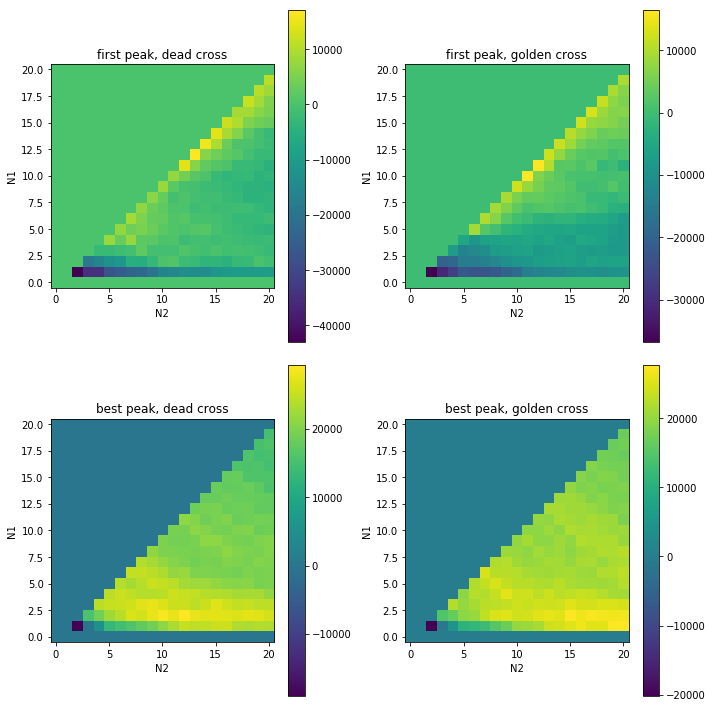

In [31]:
plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.imshow(benefits_2d[:, :, 0], origin="normal", interpolation="none")
plt.xlabel("N2")
plt.ylabel("N1")
plt.title("first peak, dead cross")
plt.colorbar()

plt.subplot(222)
plt.imshow(benefits_2d[:, :, 1], origin="normal", interpolation="none")
plt.xlabel("N2")
plt.ylabel("N1")
plt.title("first peak, golden cross")
plt.colorbar()

plt.subplot(223)
plt.imshow(benefits_best_2d[:, :, 0], origin="normal", interpolation="none")
plt.xlabel("N2")
plt.ylabel("N1")
plt.title("best peak, dead cross")
plt.colorbar()

plt.subplot(224)
plt.imshow(benefits_best_2d[:, :, 1], origin="normal", interpolation="none")
plt.xlabel("N2")
plt.ylabel("N1")
plt.title("best peak, golden cross")
plt.colorbar()

plt.tight_layout()

### dead + golden のイメージプロット

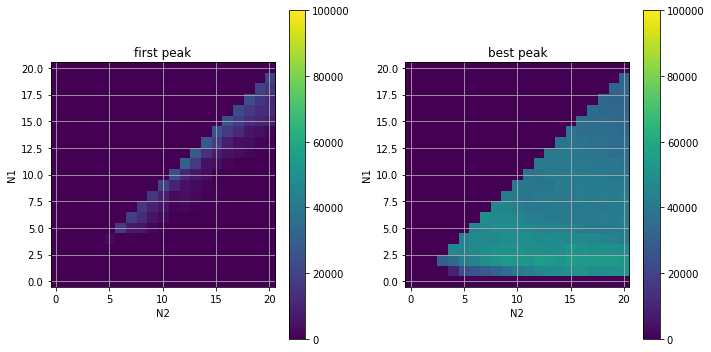

In [32]:
ymax = 1e5

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(benefits_2d.sum(axis=2), origin="normal", interpolation="none")
plt.title("first peak")
plt.xlabel("N2")
plt.ylabel("N1")
plt.colorbar()
plt.clim(0, ymax)
plt.grid(True)

plt.subplot(122)
plt.imshow(benefits_best_2d.sum(axis=2), origin="normal", interpolation="none")
plt.title("best peak")
plt.xlabel("N2")
plt.ylabel("N1")
plt.colorbar()
plt.clim(0, ymax)
plt.grid(True)

plt.tight_layout()
plt.savefig("../images/analysis_of_ohlc(20190103-20180105)-2.png")

In [33]:
print(np.where(benefits_2d.sum(axis=2)==benefits_2d.sum(axis=2).max()), benefits_2d.sum(axis=2).max())
print(np.where(benefits_best_2d.sum(axis=2)==benefits_best_2d.sum(axis=2).max()), benefits_best_2d.sum(axis=2).max())

(array([11], dtype=int64), array([12], dtype=int64)) 30597
(array([2], dtype=int64), array([15], dtype=int64)) 54883


In [36]:
benefits_2d.sum(axis=2)[17, 18]

23743

### 結果の保存

In [35]:
res = dict(
    results_list=results_list, results_list_best=results_list_best,
    N_max=N_max, comb_list=comb_list, benefits_list=benefits_list,
    benefits_list_best=benefits_list_best, benefits_2d=benefits_2d,
    benefits_best_2d=benefits_best_2d, ary=ary
)

with open("../data/analysis_of_ohlc(20190103-20180105)-2_res.pickle", "wb") as ff:
    pickle.dump(res, ff)